<a href="https://colab.research.google.com/github/ferreirabruno7/Pnad/blob/main/Lista_II_Econometria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Instale o AER e as dependências básicas de uma vez
install.packages(c("AER",        # contém ivreg()
                   "sandwich",   # erros-padrão robustos
                   "lmtest",     # coeftest()
                   "haven"))     # ler .dta (Stata)

# Depois carregue normalmente
library(haven)
library(AER)       # ivreg fica disponível
library(sandwich)
library(lmtest)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘rbibutils’, ‘cowplot’, ‘Deriv’, ‘microbenchmark’, ‘Rdpack’, ‘numDeriv’, ‘doBy’, ‘SparseM’, ‘MatrixModels’, ‘minqa’, ‘nloptr’, ‘reformulas’, ‘RcppEigen’, ‘carData’, ‘abind’, ‘pbkrtest’, ‘quantreg’, ‘lme4’, ‘car’, ‘zoo’, ‘Formula’


Loading required package: car

Loading required package: carData

Loading required package: lmtest

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: sandwich

Loading required package: survival



**Tobit e modelos de seleçãao amostral**

In [7]:

# 1. Carregar a base -----------------------------------------------------------------
# Ajuste o caminho caso o arquivo esteja noutro diretório
mroz <- read_dta("/content/MROZ.DTA")


In [8]:
# 2. Especificar o modelo IV (2SLS) --------------------------------------------------
# Variável dependente  : hours   (horas anuais trabalhadas em 1975)
# Variável endógena   : lwage   (log do salário horário)
# Variáveis exógenas  : faminc, age, educ, kidslt6, kidsge6
# Instrumentos        : motheduc, fatheduc, unem, city, huseduc
iv_mod <- ivreg(
  hours ~ lwage + faminc + age + educ + kidslt6 + kidsge6 |
          faminc + age + educ + kidslt6 + kidsge6 +
          motheduc + fatheduc + unem + city + huseduc,
  data = mroz
)

In [9]:
# 3. Resultados com erros-padrão robustos (White) ------------------------------------
robust_tab <- coeftest(iv_mod, vcov = sandwich)
print(robust_tab)


t test of coefficients:

               Estimate  Std. Error t value  Pr(>|t|)    
(Intercept)  2.3282e+03  3.9592e+02  5.8804 8.344e-09 ***
lwage        6.2489e+02  4.1797e+02  1.4951   0.13565    
faminc       2.8911e-03  7.0143e-03  0.4122   0.68042    
age         -1.0851e+01  6.8195e+00 -1.5912   0.11232    
educ        -9.6105e+01  4.0247e+01 -2.3879   0.01739 *  
kidslt6     -2.7662e+02  1.4784e+02 -1.8710   0.06204 .  
kidsge6     -9.4732e+01  3.8603e+01 -2.4540   0.01453 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



In [10]:
# 4. Elasticidade (efeito de +1 % no salário) ---------------------------------------
beta_lwage <- coef(iv_mod)["lwage"]      # coeficiente da variável log(wage)
delta_horas <- beta_lwage * 0.01         # variação nas horas para +1% no salário
cat("\nVariação prevista nas horas para um aumento de 1% no salário:",
    round(delta_horas, 2), "horas por ano\n")


Variação prevista nas horas para um aumento de 1% no salário: 6.25 horas por ano


**Questão 2**

In [11]:
# Indicador de participação (inlf = 1 se no mercado de trabalho)
mroz$I <- mroz$inlf

# Variável dependente da oferta: horas anuais trabalhadas
mroz$h   <- mroz$hours      # horas observadas só se I = 1

# Log do salário horário
mroz$lw  <- mroz$lwage      # ausente (NA) para I = 0

# Renda familiar fora do trabalho da esposa
mroz$Y   <- mroz$faminc/1000  # (escala em milhares para números menores)

# Matriz Z  (controles sempre presentes nas três equações)
Z <- model.matrix(~ age + educ + kidslt6 + kidsge6, data = mroz)[ , -1]   # sem intercepto

# Matriz Z1 (instrumentos – entram nas equações de salário e participação)
Z1 <- model.matrix(~ motheduc + fatheduc + unem + city + huseduc, data = mroz)[ , -1]

# Conveniência: número de obs. e dimensões
N      <- nrow(mroz)
k_Z    <- ncol(Z)
k_Z1   <- ncol(Z1)

In [14]:
install.packages(c("bbmle","mvtnorm","haven","sandwich","lmtest","sampleSelection"))


Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘maxLik’, ‘miscTools’, ‘systemfit’, ‘VGAM’




In [31]:
library(sampleSelection)

sel_ml <- selection( inlf  ~ motheduc + fatheduc + unem + city + huseduc + age + educ + kidslt6 + kidsge6,
                     hours ~ lwage + faminc + age + educ + kidslt6 + kidsge6,
                     data  = mroz,
                     method = "ml")   # máxima verossimilhança

summary(sel_ml)

# Elasticidade
b1_ss <- coef(sel_ml)["hours:l wage"]      # nome pode variar
0.01 * b1_ss


--------------------------------------------
Tobit 2 model (sample selection model)
Maximum Likelihood estimation
Newton-Raphson maximisation, 15 iterations
Return code 8: successive function values within relative tolerance limit (reltol)
Log-Likelihood: -3893.477 
753 observations (325 censored and 428 observed)
19 free parameters (df = 734)
Probit selection equation:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.863279   0.487274   1.772   0.0769 .  
motheduc     0.006043   0.018077   0.334   0.7382    
fatheduc    -0.015334   0.017377  -0.882   0.3778    
unem        -0.013390   0.015600  -0.858   0.3910    
city        -0.037551   0.105425  -0.356   0.7218    
huseduc     -0.050960   0.020471  -2.489   0.0130 *  
age         -0.038780   0.007680  -5.049 5.60e-07 ***
educ         0.171067   0.029532   5.793 1.03e-08 ***
kidslt6     -0.873519   0.112849  -7.741 3.28e-14 ***
kidsge6     -0.048915   0.040379  -1.211   0.2261    
Outcome equation:
              E

<NA> 
  NA

**Questão 3 **

In [33]:
############################################################
## Heckman 2-etapas com bootstrap – réplica de Mroz (1987) ##
############################################################
## Objetivo: corrigir viés de seleção sem assumir normalidade
##           nos erros das equações de salário e horas.
## Etapas:
##   1. Probit de participação  -> λ̂  (inv. razão de Mills)
##   2. OLS de ln(w)  ~ Z1 + λ̂ -> lŵ̂  (salário previsto)
##   3. OLS de horas ~ lŵ̂ + Y + Z + λ̂
##   4. Bootstrap sobre as 3 etapas para obter EP robustos
############################################################

### 0. Pacotes
pkgs <- c("haven", "dplyr", "boot")
install.packages(setdiff(pkgs, installed.packages()[,1]),
                 dependencies = TRUE)
lapply(pkgs, library, character.only = TRUE)

### 1. Dados
mroz <- read_dta("/content/MROZ.DTA") %>%
  mutate(Y  = faminc / 1000,     # escala p/ estabilizar
         I  = inlf,
         h  = hours,
         lw = lwage)

### 2. Função de uma réplica bootstrap ---------------------
heckman_2step <- function(data, idx) {
  d <- data[idx, ]            # reamostra linhas

  ##--- (a) Probit participação ----------------------------------
  probit <- glm(I ~ motheduc + fatheduc + unem + city + huseduc +
                    age + educ + kidslt6 + kidsge6,
                data = d, family = binomial(link = "probit"))
  xb      <- predict(probit, type = "link")
  lambda  <- dnorm(xb) / pnorm(xb)        # λ̂ só faz sentido para I = 1
  d$lambda <- lambda

  ##--- (b) Eq. de salário  --------------------------------------
  wage_ols <- lm(lw ~ motheduc + fatheduc + unem + city + huseduc +
                    lambda,
                 data = d, subset = (I == 1))
  d$lw_hat <- predict(wage_ols, newdata = d)   # salário previsto p/ todos

  ##--- (c) Eq. de horas  ----------------------------------------
  hours_ols <- lm(h ~ lw_hat + Y + age + educ + kidslt6 + kidsge6 +
                     lambda,
                  data = d, subset = (I == 1))

  ## Retorna coeficientes de interesse (pode ampliar se quiser)
  c(
    beta_lwage = coef(hours_ols)["lw_hat"],
    coef(hours_ols)         # todos da eq. de horas
  )
}

### 3. Bootstrap -------------------------------------------
set.seed(123)                 # reprodutibilidade
B      <- 999                 # nº de reamostragens
boot_out <- boot(data = mroz, statistic = heckman_2step, R = B)

## Erros-padrão bootstrap
boot_se <- apply(boot_out$t, 2, sd)

## Exibir resultados
estimates <- boot_out$t0
results   <- data.frame(
  Coef      = names(estimates),
  Estimate  = round(estimates, 4),
  Boot_SE   = round(boot_se, 4),
  z_boot    = round(estimates / boot_se, 2)
)
print(results, row.names = FALSE)

### 4. Elasticidade salário-horas (já corrigida)
beta <- estimates["beta_lwage"]
delta_h <- 0.01 * beta
cat("\nAumento de 1 % no salário previsto →",
    round(delta_h, 2), "horas/ano\n")


[[1]]
 [1] "boot"            "dplyr"           "sampleSelection" "maxLik"         
 [5] "miscTools"       "bbmle"           "stats4"          "mvtnorm"        
 [9] "AER"             "survival"        "sandwich"        "lmtest"         
[13] "zoo"             "car"             "carData"         "haven"          
[17] "stats"           "graphics"        "grDevices"       "utils"          
[21] "datasets"        "methods"         "base"           

[[2]]
 [1] "boot"            "dplyr"           "sampleSelection" "maxLik"         
 [5] "miscTools"       "bbmle"           "stats4"          "mvtnorm"        
 [9] "AER"             "survival"        "sandwich"        "lmtest"         
[13] "zoo"             "car"             "carData"         "haven"          
[17] "stats"           "graphics"        "grDevices"       "utils"          
[21] "datasets"        "methods"         "base"           

[[3]]
 [1] "boot"            "dplyr"           "sampleSelection" "maxLik"         
 [5] "miscTools"       "bbmle"           "stats4"          "mvtnorm"        
 [9] "AER"             "survival"        "sandwich"        "lmtest"         
[13] "zoo"             "car"             "carData"         "haven"          
[17] "stats"           "graphics"        "grDevices"       "utils"          
[21] "datasets"        "methods"         "base"

              Coef  Estimate  Boot_SE z_boot
 beta_lwage.lw_hat -597.8576 517.0991  -1.16
       (Intercept) 3167.7302 613.4794   5.16
            lw_hat -597.8576 517.0991  -1.16
                 Y   14.8985   4.4663   3.34
               age   -1.5115  14.1336  -0.11
              educ  -65.0517  54.2771  -1.20
           kidslt6  -73.9319 358.6915  -0.21
           kidsge6 -112.9224  35.2279  -3.21
            lambda -752.8594 515.7992  -1.46

Aumento de 1 % no salário previsto → NA horas/ano


**Questão 4 **

In [34]:
## depois de rodar iv_mod com AER::ivreg
summary(iv_mod, vcov = sandwich, diagnostics = TRUE)



Call:
ivreg(formula = hours ~ lwage + faminc + age + educ + kidslt6 + 
    kidsge6 | faminc + age + educ + kidslt6 + kidsge6 + motheduc + 
    fatheduc + unem + city + huseduc, data = mroz)

Residuals:
    Min      1Q  Median      3Q     Max 
-2438.6  -548.0    31.2   456.4  5429.2 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.328e+03  3.959e+02   5.880 8.34e-09 ***
lwage        6.249e+02  4.180e+02   1.495   0.1356    
faminc       2.891e-03  7.014e-03   0.412   0.6804    
age         -1.085e+01  6.820e+00  -1.591   0.1123    
educ        -9.611e+01  4.025e+01  -2.388   0.0174 *  
kidslt6     -2.766e+02  1.478e+02  -1.871   0.0620 .  
kidsge6     -9.473e+01  3.860e+01  -2.454   0.0145 *  

Diagnostic tests:
                 df1 df2 statistic p-value  
Weak instruments   5 417     2.145  0.0593 .
Wu-Hausman         1 420     3.629  0.0575 .
Sargan             4  NA     3.369  0.4980  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 

**Exercício de Matching**

In [36]:
## -----------------------------------------------------------
## Pacotes
## -----------------------------------------------------------
pkgs <- c("haven", "dplyr", "tableone")
install.packages(setdiff(pkgs, installed.packages()[,1]),
                 dependencies = TRUE)
lapply(pkgs, library, character.only = TRUE)

## -----------------------------------------------------------
## Ler dados
## -----------------------------------------------------------
df <- read_dta("smoking2subsp.dta") %>%
  mutate(treat = tobacco)            # 1 = fumou

## -----------------------------------------------------------
## (A) ATE ingênuo: diferença de médias do peso ao nascer
## -----------------------------------------------------------
ate  <- with(df, mean(dbirwt[treat == 1], na.rm = TRUE) -
                  mean(dbirwt[treat == 0], na.rm = TRUE))
cat("ATE ingênuo (fumante – não fumante) =",
    round(ate, 1), "gramas\n")

## Intervalo de confiança (t‐test Welch)
bw_t <- with(df, t.test(dbirwt ~ treat))
cat("IC 95%: [", round(bw_t$conf.int[1],1), ",",
                 round(bw_t$conf.int[2],1), "]\n\n")

## -----------------------------------------------------------
## (B) Examinar a hipótese de aleatoriedade
##     – comparação de médias das covariáveis
## -----------------------------------------------------------
covars <- c("dmage","dmeduc","mblack","motherr","mhispan","dmar",
            "estranjerob","dfage","dfeduc","fblack","fotherr","fhispan",
            "alcohol","drink","tripre1","tripre2","tripre3","tripre0",
            "nprevist","first","dlivord","natimorto","disllb","premature",
            "pre4000","plural","phyper","diabetes","anemia")

tab1 <- CreateTableOne(vars = covars, strata = "treat",
                       data = df, test = TRUE)
print(tab1, smd = TRUE)     # inclui diferenças padronizadas (SMD)

## -----------------------------------------------------------
## (C) Sobreposição rápida: fração de fumantes
## -----------------------------------------------------------
prop_fum <- mean(df$treat, na.rm = TRUE)
cat("\nProporção de gestantes que fumam =", round(prop_fum,3), "\n")


[[1]]
 [1] "tableone"        "boot"            "dplyr"           "sampleSelection"
 [5] "maxLik"          "miscTools"       "bbmle"           "stats4"         
 [9] "mvtnorm"         "AER"             "survival"        "sandwich"       
[13] "lmtest"          "zoo"             "car"             "carData"        
[17] "haven"           "stats"           "graphics"        "grDevices"      
[21] "utils"           "datasets"        "methods"         "base"           

[[2]]
 [1] "tableone"        "boot"            "dplyr"           "sampleSelection"
 [5] "maxLik"          "miscTools"       "bbmle"           "stats4"         
 [9] "mvtnorm"         "AER"             "survival"        "sandwich"       
[13] "lmtest"          "zoo"             "car"             "carData"        
[17] "haven"           "stats"           "graphics"        "grDevices"      
[21] "utils"           "datasets"        "methods"         "base"           

[[3]]
 [1] "tableone"        "boot"            "dplyr"           "sampleSelection"
 [5] "maxLik"          "miscTools"       "bbmle"           "stats4"         
 [9] "mvtnorm"         "AER"             "survival"        "sandwich"       
[13] "lmtest"          "zoo"             "car"             "carData"        
[17] "haven"           "stats"           "graphics"        "grDevices"      
[21] "utils"           "datasets"        "methods"         "base"

ATE ingênuo (fumante – não fumante) = -253.7 gramas
IC 95%: [ 236.1 , 271.3 ]



Warning message in ModuleReturnVarsExist(vars, data):
“The data frame does not have: estranjerob natimorto premature diabetes  Dropped”


                      Stratified by treat
                       0             1             p      test SMD   
  n                    22686          5144                           
  dmage (mean (SD))    27.24 (5.47)  25.41 (5.30)  <0.001       0.340
  dmeduc (mean (SD))   13.13 (2.25)  11.85 (1.60)  <0.001       0.654
  mblack (mean (SD))    0.11 (0.31)   0.14 (0.35)  <0.001       0.090
  motherr (mean (SD))   0.02 (0.13)   0.00 (0.06)  <0.001       0.135
  mhispan (mean (SD))   0.03 (0.16)   0.02 (0.13)  <0.001       0.061
  dmar (mean (SD))      0.18 (0.38)   0.41 (0.49)  <0.001       0.529
  dfage (mean (SD))    29.55 (6.21)  28.43 (6.57)  <0.001       0.175
  dfeduc (mean (SD))   13.26 (2.37)  12.03 (1.74)  <0.001       0.595
  fblack (mean (SD))    0.12 (0.32)   0.16 (0.36)  <0.001       0.111
  fotherr (mean (SD))   0.02 (0.12)   0.00 (0.06)  <0.001       0.129
  fhispan (mean (SD))   0.03 (0.17)   0.03 (0.16)   0.113       0.025
  alcohol (mean (SD))   0.01 (0.09)   0.05 (0.22

[[1]]
 [1] "tableone"        "boot"            "dplyr"           "sampleSelection"
 [5] "maxLik"          "miscTools"       "bbmle"           "stats4"         
 [9] "mvtnorm"         "AER"             "survival"        "sandwich"       
[13] "lmtest"          "zoo"             "car"             "carData"        
[17] "haven"           "stats"           "graphics"        "grDevices"      
[21] "utils"           "datasets"        "methods"         "base"           

[[2]]
 [1] "tableone"        "boot"            "dplyr"           "sampleSelection"
 [5] "maxLik"          "miscTools"       "bbmle"           "stats4"         
 [9] "mvtnorm"         "AER"             "survival"        "sandwich"       
[13] "lmtest"          "zoo"             "car"             "carData"        
[17] "haven"           "stats"           "graphics"        "grDevices"      
[21] "utils"           "datasets"        "methods"         "base"           

[[3]]
 [1] "ggplot2"         "tableone"        "boot"            "dplyr"          
 [5] "sampleSelection" "maxLik"          "miscTools"       "bbmle"          
 [9] "stats4"          "mvtnorm"         "AER"             "survival"       
[13] "sandwich"        "lmtest"          "zoo"             "car"            
[17] "carData"         "haven"           "stats"           "graphics"       
[21] "grDevices"       "utils"           "datasets"        "methods"        
[25] "base"           

[[4]]
 [1] "ggplot2"         "tableone"        "boot"            "dplyr"          
 [5] "sampleSelection" "maxLik"          "miscTools"       "bbmle"          
 [9] "stats4"          "mvtnorm"         "AER"             "survival"       
[13] "sandwich"        "lmtest"          "zoo"             "car"            
[17] "carData"         "haven"           "stats"           "graphics"       
[21] "grDevices"       "utils"           "datasets"        "methods"        
[25] "base"           

[[5]]
 [1] "ggplot2"         "tableone"        "boot"            "dplyr"          
 [5] "sampleSelection" "maxLik"          "miscTools"       "bbmle"          
 [9] "stats4"          "mvtnorm"         "AER"             "survival"       
[13] "sandwich"        "lmtest"          "zoo"             "car"            
[17] "carData"         "haven"           "stats"           "graphics"       
[21] "grDevices"       "utils"           "datasets"        "methods"        
[25] "base"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0182  0.1633  0.2166  0.2637  0.3646  0.9516 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.002262 0.083787 0.148530 0.166959 0.195680 0.904090 


--- Estrato 1 ---------------------------
dmage :  p =  0.597 
dmeduc :  p =  0 
mblack :  p =  0 
motherr :  p =  0.217 
mhispan :  p =  0.009 
dmar :  p =  0.8 
dfage :  p =  0.521 
dfeduc :  p =  0 
fblack :  p =  0 
fotherr :  p =  0.085 
fhispan :  p =  0.016 
tripre1 :  p =  0.174 
tripre2 :  p =  0.06 
tripre3 :  p =  0 
tripre0 :  p =  NaN 
nprevist :  p =  0.789 

--- Estrato 2 ---------------------------
dmage :  p =  0.008 
dmeduc :  p =  0 
mblack :  p =  0.001 
motherr :  p =  0.33 
mhispan :  p =  0.256 
dmar :  p =  0.18 
dfage :  p =  0 
dfeduc :  p =  0 
fblack :  p =  0 
fotherr :  p =  0.889 
fhispan :  p =  0.261 
tripre1 :  p =  0.205 
tripre2 :  p =  0.364 
tripre3 :  p =  0.33 
tripre0 :  p =  0.801 
nprevist :  p =  0.542 

--- Estrato 3 ---------------------------
dmage :  p =  0.967 
dmeduc :  p =  0.046 
mblack :  p =  0.834 
motherr :  p =  0.002 
mhispan :  p =  0.113 
dmar :  p =  0.715 
dfage :  p =  0.19 
dfeduc :  p =  0.179 
fblack :  p =  0.332 
foth

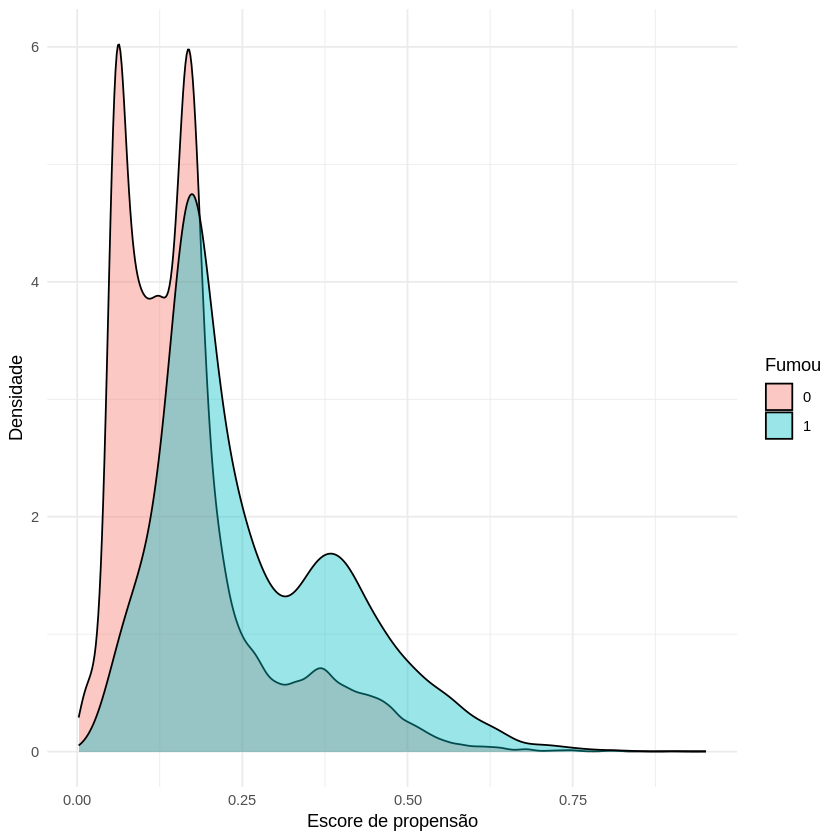

In [37]:
############################################################
## 0. Pacotes
############################################################
pkgs <- c("haven","dplyr","ggplot2","tableone","boot")
install.packages(setdiff(pkgs, installed.packages()[,1]),
                 dependencies = TRUE)
lapply(pkgs, library, character.only = TRUE)

############################################################
## 1. Ler dados e selecionar variáveis socioeconômicas
############################################################
df <- read_dta("smoking2subsp.dta") %>%
  mutate(treat = tobacco)              # 1 = fumou

## Conjunto de covariáveis socioeconômicas básicas
covars <- c("dmage","dmeduc","mblack","motherr","mhispan","dmar",
            "dfage","dfeduc","fblack","fotherr","fhispan",
            "tripre1","tripre2","tripre3","tripre0","nprevist")

############################################################
## 2. Estimar o escore de propensão (logit)
############################################################
ps_formula <- as.formula(paste("treat ~", paste(covars, collapse = "+")))
ps_mod <- glm(ps_formula, family = binomial, data = df)
df$pscore <- predict(ps_mod, type = "response")

############################################################
## 3. Verificar suporte comum (sobreposição)
############################################################
ggplot(df, aes(x = pscore, fill = factor(treat))) +
  geom_density(alpha = .4) +
  labs(fill = "Fumou", x = "Escore de propensão", y = "Densidade") +
  theme_minimal()

## Resumo numérico
summary(df$pscore[df$treat==1]); summary(df$pscore[df$treat==0])

## Cortar caudas sem sobreposição
lo <- max(min(df$pscore[df$treat==1]), min(df$pscore[df$treat==0]))
hi <- min(max(df$pscore[df$treat==1]), max(df$pscore[df$treat==0]))
df_cs <- df %>% filter(pscore >= lo & pscore <= hi)

############################################################
## 4. Dividir em 5 estratos (quintis) no suporte comum
############################################################
df_cs$stratum <- ntile(df_cs$pscore, 5)

############################################################
## 5. Teste de diferenças de médias dentro de cada estrato
############################################################
for(s in 1:5){
  cat("\n--- Estrato", s, "---------------------------\n")
  dtemp <- filter(df_cs, stratum == s)
  for(v in covars){
    test <- t.test(dtemp[[v]] ~ dtemp$treat)
    cat(v, ":  p = ", round(test$p.value,3), "\n")
  }
}

############################################################
## 6. Diferença padronizada de médias (SMD) por estrato
############################################################
smd_fun <- function(x, g){
  m1 <- mean(x[g==1]);  m0 <- mean(x[g==0])
  s  <- sqrt( (var(x[g==1]) + var(x[g==0])) / 2 )
  abs(m1 - m0)/s
}

smd_table <- data.frame(Stratum = rep(1:5, each = length(covars)),
                        Var      = rep(covars, times = 5),
                        SMD      = NA)

for(s in 1:5){
  dtemp <- filter(df_cs, stratum == s)
  for(v in covars){
    smd_table$SMD[smd_table$Stratum==s & smd_table$Var==v] <-
      smd_fun(dtemp[[v]], dtemp$treat)
  }
}

## Checar critério de Imbens & Wooldridge (SMD ≤ 0,25)
viol <- smd_table %>% filter(SMD > .25)
if(nrow(viol)==0){
  cat("\nTodos os SMD ≤ 0,25  ⇒  balance adequado em cada estrato.\n")
} else {
  cat("\nVariáveis ainda desequilibradas (SMD > 0,25):\n")
  print(viol)
}

############################################################
## 7. Estimar o efeito dentro de cada estrato e agregar
############################################################
ate_strata <- df_cs %>%
  group_by(stratum) %>%
  summarise(ATE = mean(dbirwt[treat==1]) -
                   mean(dbirwt[treat==0]),
            n    = n())

## Agregar por ponderação do tamanho do estrato (Hajek)
ate_weighted <- with(ate_strata, sum(ATE * n) / sum(n))
print(ate_strata)
cat("\nATE ponderado (5 estratos) =", round(ate_weighted,1), "g\n")


In [39]:
#########################################
# OLS com efeitos fixos de idade e educação
#########################################
ols_fe <- lm(dbirwt ~ treat +
               factor(dmage) +                # FE idade da mãe
               factor(dmeduc) +               # FE escolaridade da mãe
               factor(dfeduc) +               # FE escolaridade do pai
               mblack + motherr + mhispan + dmar +
               fblack + fotherr + fhispan +
               alcohol + drink +
               tripre1 + tripre2 + tripre3 + tripre0 + nprevist +
               first + dlivord + disllb +
               pre4000 + plural + phyper + anemia,
             data = df_cs)                    # use a amostra no suporte comum

beta_ols <- coef(ols_fe)["treat"]
cat("Coeficiente do tabagismo no OLS com FE =", round(beta_ols, 1), "gramas\n")


Coeficiente do tabagismo no OLS com FE = -212.6 gramas


In [43]:
############################################################
## Nearest-Neighbor Matching (1:1, sem reposição)
##   – opção “A”: MatchIt calcula o escore via logit
############################################################
## Pacotes
############################################################
pkgs <- c("haven", "dplyr", "MatchIt", "tableone")
install.packages(
  setdiff(pkgs, rownames(installed.packages())),
  dependencies = TRUE
)
lapply(pkgs, library, character.only = TRUE)

############################################################
## 1. Ler dados e definir tratamento
############################################################
df <- read_dta("smoking2subsp.dta") %>%
  mutate(treat = tobacco)        # 1 = fumou

############################################################
## 2. Covariáveis socioeconômicas para o logit do PS
############################################################
covars <- c(
  "dmage", "dmeduc", "mblack", "motherr", "mhispan", "dmar",
  "dfage", "dfeduc", "fblack", "fotherr", "fhispan",
  "tripre1", "tripre2", "tripre3", "tripre0", "nprevist"
)

############################################################
## 3. Estimar o escore e restringir ao suporte comum
############################################################
ps_mod <- glm(
  as.formula(paste("treat ~", paste(covars, collapse = "+"))),
  family = binomial, data = df
)
df$pscore <- ps_mod$fitted

lo <- max(
  min(df$pscore[df$treat == 1]),
  min(df$pscore[df$treat == 0])
)
hi <- min(
  max(df$pscore[df$treat == 1]),
  max(df$pscore[df$treat == 0])
)
df_sc <- df %>% filter(pscore >= lo, pscore <= hi)
cat("Suporte comum:", sprintf("[%.3f, %.3f]\n", lo, hi))

############################################################
## 4. Matching nearest neighbor (MatchIt calcula o logit)
############################################################
match_nn <- matchit(
  treat ~ dmage + dmeduc + mblack + motherr + mhispan + dmar +
           dfage + dfeduc + fblack + fotherr + fhispan +
           tripre1 + tripre2 + tripre3 + tripre0 + nprevist,
  data      = df_sc,
  method    = "nearest",   # vizinho mais próximo
  ratio     = 1,           # 1:1
  replace   = FALSE,
  distance  = "logit"      # MatchIt estima o PS internamente
)

matched <- match.data(match_nn)
cat("Observações pareadas:", nrow(matched), "\n")

############################################################
## 5. ATT – diferença média pareada
############################################################
ATT_nn <- with(
  matched,
  mean(dbirwt[treat == 1]) - mean(dbirwt[treat == 0])
)
cat("ATT (nearest-neighbor 1:1) =", round(ATT_nn, 1), "gramas\n")

############################################################
## 6. (Opcional) Checar balanço após matching
############################################################
tab_after <- CreateTableOne(vars = covars, strata = "treat",
                            data = matched, test = FALSE)
print(tab_after, smd = TRUE)   # SMDs devem cair para < 0,10–0,25


[[1]]
 [1] "MatchIt"         "ggplot2"         "tableone"        "boot"           
 [5] "dplyr"           "sampleSelection" "maxLik"          "miscTools"      
 [9] "bbmle"           "stats4"          "mvtnorm"         "AER"            
[13] "survival"        "sandwich"        "lmtest"          "zoo"            
[17] "car"             "carData"         "haven"           "stats"          
[21] "graphics"        "grDevices"       "utils"           "datasets"       
[25] "methods"         "base"           

[[2]]
 [1] "MatchIt"         "ggplot2"         "tableone"        "boot"           
 [5] "dplyr"           "sampleSelection" "maxLik"          "miscTools"      
 [9] "bbmle"           "stats4"          "mvtnorm"         "AER"            
[13] "survival"        "sandwich"        "lmtest"          "zoo"            
[17] "car"             "carData"         "haven"           "stats"          
[21] "graphics"        "grDevices"       "utils"           "datasets"       
[25] "methods"         "base"           

[[3]]
 [1] "MatchIt"         "ggplot2"         "tableone"        "boot"           
 [5] "dplyr"           "sampleSelection" "maxLik"          "miscTools"      
 [9] "bbmle"           "stats4"          "mvtnorm"         "AER"            
[13] "survival"        "sandwich"        "lmtest"          "zoo"            
[17] "car"             "carData"         "haven"           "stats"          
[21] "graphics"        "grDevices"       "utils"           "datasets"       
[25] "methods"         "base"           

[[4]]
 [1] "MatchIt"         "ggplot2"         "tableone"        "boot"           
 [5] "dplyr"           "sampleSelection" "maxLik"          "miscTools"      
 [9] "bbmle"           "stats4"          "mvtnorm"         "AER"            
[13] "survival"        "sandwich"        "lmtest"          "zoo"            
[17] "car"             "carData"         "haven"           "stats"          
[21] "graphics"        "grDevices"       "utils"           "datasets"       
[25] "methods"         "base"

Suporte comum: [0.018, 0.904]
Observações pareadas: 10286 
ATT (nearest-neighbor 1:1) = -208.3 gramas
                      Stratified by treat
                       0            1            SMD   
  n                     5143         5143              
  dmage (mean (SD))    25.36 (5.82) 25.41 (5.30)  0.008
  dmeduc (mean (SD))   11.70 (2.00) 11.85 (1.59)  0.084
  mblack (mean (SD))    0.15 (0.36)  0.14 (0.35)  0.026
  motherr (mean (SD))   0.01 (0.07)  0.00 (0.06)  0.035
  mhispan (mean (SD))   0.02 (0.14)  0.02 (0.13)  0.007
  dmar (mean (SD))      0.38 (0.49)  0.41 (0.49)  0.054
  dfage (mean (SD))    28.31 (7.13) 28.43 (6.57)  0.018
  dfeduc (mean (SD))   11.86 (2.15) 12.03 (1.73)  0.088
  fblack (mean (SD))    0.16 (0.37)  0.16 (0.36)  0.023
  fotherr (mean (SD))   0.00 (0.07)  0.00 (0.06)  0.022
  fhispan (mean (SD))   0.03 (0.16)  0.03 (0.16)  0.007
  tripre1 (mean (SD))   0.72 (0.45)  0.72 (0.45)  0.017
  tripre2 (mean (SD))   0.21 (0.41)  0.21 (0.41)  0.004
  tripre3 (mean 

**GMM**

In [46]:
############################################################
## Pacotes
############################################################
pkgs <- c("haven","dplyr","lmtest","sandwich")
install.packages(setdiff(pkgs, installed.packages()[,1]), dependencies=TRUE)
lapply(pkgs, library, character.only = TRUE)

############################################################
## Ler dados e preparar variáveis reais
############################################################
cigar <- read_dta("/content/cigar.dta") %>%        # use o nome exato do arquivo
  arrange(state, year) %>%                    # já existe state e year
  mutate(
    price_r = price / (cpi/100),
    pmin_r  = pimin / (cpi/100),
    ndi_r   = ndi   / (cpi/100),
    ln_C    = log(sales),        # C -> 'sales' na versão minúscula
    ln_P    = log(price_r),
    ln_Pmin = log(pmin_r),
    ln_Y    = log(ndi_r)
  ) %>%
  group_by(state) %>%
  mutate(ln_C_lag = lag(ln_C)) %>%            # defasagem
  ungroup() %>%
  filter(!is.na(ln_C_lag))

############################################################
## MQO robusto
############################################################
ols <- lm(ln_C ~ ln_C_lag + ln_P + ln_Pmin + ln_Y, data = cigar)
rob  <- coeftest(ols, vcov = vcovHC(ols, type = "HC1"))
print(rob)

############################################################
## Elasticidades
############################################################
b1 <- coef(ols)["ln_C_lag"]
b2 <- coef(ols)["ln_P"]
b3 <- coef(ols)["ln_Pmin"]
b4 <- coef(ols)["ln_Y"]

cat("\nElasticidade-preço curto  =", round(b2,3),
    "\nElasticidade-preço longo  =", round(b2/(1-b1),3),
    "\nElasticidade-renda curto  =", round(b4,3),
    "\nElasticidade-renda longo  =", round(b4/(1-b1),3),
    "\nElasticidade cruzada curto =", round(b3,3),
    "\nElasticidade cruzada longo =", round(b3/(1-b1),3), "\n")


[[1]]
 [1] "MatchIt"         "ggplot2"         "tableone"        "boot"           
 [5] "dplyr"           "sampleSelection" "maxLik"          "miscTools"      
 [9] "bbmle"           "stats4"          "mvtnorm"         "AER"            
[13] "survival"        "sandwich"        "lmtest"          "zoo"            
[17] "car"             "carData"         "haven"           "stats"          
[21] "graphics"        "grDevices"       "utils"           "datasets"       
[25] "methods"         "base"           

[[2]]
 [1] "MatchIt"         "ggplot2"         "tableone"        "boot"           
 [5] "dplyr"           "sampleSelection" "maxLik"          "miscTools"      
 [9] "bbmle"           "stats4"          "mvtnorm"         "AER"            
[13] "survival"        "sandwich"        "lmtest"          "zoo"            
[17] "car"             "carData"         "haven"           "stats"          
[21] "graphics"        "grDevices"       "utils"           "datasets"       
[25] "methods"         "base"           

[[3]]
 [1] "MatchIt"         "ggplot2"         "tableone"        "boot"           
 [5] "dplyr"           "sampleSelection" "maxLik"          "miscTools"      
 [9] "bbmle"           "stats4"          "mvtnorm"         "AER"            
[13] "survival"        "sandwich"        "lmtest"          "zoo"            
[17] "car"             "carData"         "haven"           "stats"          
[21] "graphics"        "grDevices"       "utils"           "datasets"       
[25] "methods"         "base"           

[[4]]
 [1] "MatchIt"         "ggplot2"         "tableone"        "boot"           
 [5] "dplyr"           "sampleSelection" "maxLik"          "miscTools"      
 [9] "bbmle"           "stats4"          "mvtnorm"         "AER"            
[13] "survival"        "sandwich"        "lmtest"          "zoo"            
[17] "car"             "carData"         "haven"           "stats"          
[21] "graphics"        "grDevices"       "utils"           "datasets"       
[25] "methods"         "base"


t test of coefficients:

              Estimate Std. Error  t value  Pr(>|t|)    
(Intercept)  0.7201339  0.0723828   9.9490 < 2.2e-16 ***
ln_C_lag     0.9727879  0.0087271 111.4677 < 2.2e-16 ***
ln_P        -0.0829177  0.0156825  -5.2873 1.450e-07 ***
ln_Pmin      0.0160333  0.0141915   1.1298    0.2588    
ln_Y        -0.0322328  0.0059644  -5.4042 7.706e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Elasticidade-preço curto  = -0.083 
Elasticidade-preço longo  = -3.047 
Elasticidade-renda curto  = -0.032 
Elasticidade-renda longo  = -1.185 
Elasticidade cruzada curto = 0.016 
Elasticidade cruzada longo = 0.589 


In [50]:
############################################################
## Two-way FE sem ‘plm’: usa apenas lm + dummies
############################################################
library(haven)      # já instalado antes
library(lmtest); library(sandwich)

## 1. Ler base (ajuste o nome do arquivo)
cigar <- read_dta("/content/cigar.dta")
names(cigar) <- tolower(names(cigar))   # padroniza

## 2. Variáveis reais e logs
cigar$price_r <- cigar$price / (cigar$cpi/100)
cigar$pmin_r  <- cigar$pimin / (cigar$cpi/100)
cigar$ndi_r   <- cigar$ndi   / (cigar$cpi/100)

cigar$ln_c    <- log(cigar$sales)
cigar$ln_p    <- log(cigar$price_r)
cigar$ln_pmin <- log(cigar$pmin_r)
cigar$ln_y    <- log(cigar$ndi_r)

## 3. Defasagem de ln_c por Estado
cigar <- cigar[order(cigar$state, cigar$year), ]
cigar$ln_c_lag <- ave(cigar$ln_c, cigar$state,
                      FUN = function(x) c(NA, head(x, -1)))

## 4. Remove linhas sem defasagem (primeiro ano de cada Estado)
cigar <- subset(cigar, !is.na(ln_c_lag))

## 5. Two-way FE: lm com factor(state) e factor(year)
twfe_lm <- lm(ln_c ~ ln_c_lag + ln_p + ln_pmin + ln_y +
                        factor(state) + factor(year),
              data = cigar)

## 6. Erros-padrão robustos (White HC1)
coefs <- coeftest(twfe_lm,
                  vcov = vcovHC(twfe_lm, type = "HC1"))
print(coefs)

## 7. Elasticidades
b1 <- coef(twfe_lm)["ln_c_lag"]
b2 <- coef(twfe_lm)["ln_p"]
b3 <- coef(twfe_lm)["ln_pmin"]
b4 <- coef(twfe_lm)["ln_y"]

elastic <- function(beta) c(curto = beta,
                            longo  = beta / (1 - b1))

out <- rbind(
  preco          = round(elastic(b2),  3),
  preco_cruzado  = round(elastic(b3),  3),
  renda          = round(elastic(b4),  3)
)
print(out)



t test of coefficients:

                   Estimate  Std. Error t value  Pr(>|t|)    
(Intercept)      1.01665992  0.28217249  3.6030 0.0003269 ***
ln_c_lag         0.83024418  0.02032016 40.8582 < 2.2e-16 ***
ln_p            -0.29168809  0.02928061 -9.9618 < 2.2e-16 ***
ln_pmin          0.03545610  0.02932598  1.2090 0.2268775    
ln_y             0.10685188  0.02764293  3.8654 0.0001166 ***
factor(state)3  -0.04119916  0.00983269 -4.1900 2.984e-05 ***
factor(state)4   0.01373662  0.00818534  1.6782 0.0935575 .  
factor(state)5  -0.06758592  0.01300436 -5.1972 2.359e-07 ***
factor(state)7  -0.03834200  0.01557534 -2.4617 0.0139612 *  
factor(state)8   0.01504612  0.01004935  1.4972 0.1345866    
factor(state)9  -0.04549644  0.02002306 -2.2722 0.0232427 *  
factor(state)10  0.00820002  0.00986837  0.8309 0.4061658    
factor(state)11 -0.00967114  0.00683090 -1.4158 0.1570838    
factor(state)13 -0.04546684  0.01022112 -4.4483 9.420e-06 ***
factor(state)14 -0.02942413  0.01277415 -2.3

In [60]:
############################################################
## Pacotes
############################################################
library(haven); library(dplyr); library(plm)

############################################################
## 1. Ler base e criar variáveis
############################################################
cigar <- read_dta("/content/cigar.dta")
names(cigar) <- tolower(names(cigar))

cigar <- cigar %>%
  mutate(price_r = price/(cpi/100),
         pmin_r  = pimin/(cpi/100),
         ndi_r   = ndi  /(cpi/100),
         ln_c    = log(sales),
         ln_p    = log(price_r),
         ln_pmin = log(pmin_r),
         ln_y    = log(ndi_r))

## 2. Verificar dados antes de prosseguir
print("=== Estrutura dos dados ===")
print(summary(cigar[c("ln_c", "ln_p", "ln_pmin", "ln_y")]))
print(paste("Número de observações:", nrow(cigar)))
print(paste("Número de estados:", length(unique(cigar$state))))
print(paste("Anos disponíveis:", min(cigar$year), "-", max(cigar$year)))

## 3. Dummies para anos (removendo um ano para evitar colinearidade)
years_keep <- c(1970, 1972:1991)  # removendo 1965 como categoria base
for (yy in years_keep) {
  cigar[[paste0("d", yy)]] <- as.numeric(cigar$year == yy)
}
time_dums <- paste0("d", years_keep)

## 4. Transformar em painel
pdata <- pdata.frame(cigar, index = c("state","year"))

## 5. Verificar se há observações suficientes após lag
print("=== Verificação após criar lag ===")
test_data <- pdata[!is.na(lag(pdata$ln_c, 1)), ]
print(paste("Observações disponíveis após lag:", nrow(test_data)))

## 6. Modelo Arellano-Bond simplificado (começar simples)
print("=== Tentativa 1: Modelo básico ===")
try({
  form_simple <- ln_c ~ lag(ln_c,1) + ln_p + ln_y | lag(ln_c, 2:4) | ln_p + ln_y

  ab_simple <- pgmm(form_simple,
                    data = pdata,
                    effect = "individual",
                    model = "onestep",      # começar com one-step
                    transformation = "d")

  print(summary(ab_simple, robust = TRUE))
  print("Modelo básico funcionou!")
})

## 7. Se o básico funcionar, tentar com mais variáveis
print("=== Tentativa 2: Modelo com mais variáveis ===")
try({
  # Reduzir número de dummies temporais para evitar over-identification
  years_reduced <- c(1975, 1980, 1985, 1990)  # apenas alguns anos
  time_dums_red <- paste0("d", years_reduced)

  form_extended <- as.formula(
    paste("ln_c ~ lag(ln_c,1) + ln_p + ln_pmin + ln_y +",
          paste(time_dums_red, collapse = " + "),
          "| lag(ln_c, 2:4) |",
          "ln_p + ln_pmin + ln_y +",
          paste(time_dums_red, collapse = " + "))
  )

  ab_extended <- pgmm(form_extended,
                     data = pdata,
                     effect = "individual",
                     model = "onestep",
                     transformation = "d")

  print(summary(ab_extended, robust = TRUE))
  print("Modelo estendido funcionou!")
})

## 8. Versão two-step (se one-step funcionar)
print("=== Tentativa 3: Two-step GMM ===")
try({
  form_twostep <- ln_c ~ lag(ln_c,1) + ln_p + ln_y | lag(ln_c, 2:3) | ln_p + ln_y

  ab_twostep <- pgmm(form_twostep,
                    data = pdata,
                    effect = "individual",
                    model = "twosteps",
                    transformation = "d")

  print(summary(ab_twostep, robust = TRUE))

  # Testes de especificação
  print("=== Testes de Especificação ===")
  if(!is.null(ab_twostep$sargan)) {
    print(paste("Teste de Sargan p-value:", round(ab_twostep$sargan$p.value, 4)))
  }
})

## 9. Diagnósticos adicionais
print("=== Diagnósticos ===")
# Verificar correlação entre variáveis
cor_matrix <- cor(cigar[c("ln_c", "ln_p", "ln_pmin", "ln_y")], use = "complete.obs")
print("Matriz de correlação:")
print(round(cor_matrix, 3))

# Verificar se há variância suficiente
print("Desvios padrão:")
print(sapply(cigar[c("ln_c", "ln_p", "ln_pmin", "ln_y")], sd, na.rm = TRUE))

[1] "=== Estrutura dos dados ==="
      ln_c            ln_p          ln_pmin           ln_y      
 Min.   :3.978   Min.   :3.995   Min.   :3.995   Min.   :8.371  
 1st Qu.:4.681   1st Qu.:4.400   1st Qu.:4.316   1st Qu.:9.028  
 Median :4.797   Median :4.504   Median :4.411   Median :9.162  
 Mean   :4.793   Mean   :4.499   Mean   :4.411   Mean   :9.150  
 3rd Qu.:4.892   3rd Qu.:4.593   3rd Qu.:4.510   3rd Qu.:9.292  
 Max.   :5.697   Max.   :4.969   Max.   :4.846   Max.   :9.722  
[1] "Número de observações: 1380"
[1] "Número de estados: 46"
[1] "Anos disponíveis: 63 - 92"
[1] "=== Verificação após criar lag ==="
[1] "Observações disponíveis após lag: 1334"
[1] "=== Tentativa 1: Modelo básico ==="


Warning message in pgmm(form_simple, data = pdata, effect = "individual", model = "onestep", :
“the second-step matrix is singular, a general inverse is used”
Warning message in vcovHC.pgmm(object):
“a general inverse is used”


Oneway (individual) effect One-step model Difference GMM 

Call:
pgmm(formula = form_simple, data = pdata, effect = "individual", 
    model = "onestep", transformation = "d")

Balanced Panel: n = 46, T = 30, N = 1380

Number of Observations Used: 1288
Residuals:
      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-0.3069227 -0.0246714  0.0001501  0.0019728  0.0271453  0.2492052 

Coefficients:
              Estimate Std. Error z-value  Pr(>|z|)    
lag(ln_c, 1)  0.823610   0.031110 26.4740 < 2.2e-16 ***
ln_p         -0.149666   0.019210 -7.7912 6.637e-15 ***
ln_y         -0.054741   0.015082 -3.6295 0.0002839 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Sargan test: chisq(80) = 46 (p-value = 0.99918)
Autocorrelation test (1): normal = -5.333672 (p-value = 9.6246e-08)
Autocorrelation test (2): normal = 2.139841 (p-value = 0.032368)
Wald test for coefficients: chisq(3) = 5065.904 (p-value = < 2.22e-16)
[1] "Modelo básico funcionou!"
[1] "=== Ten

Warning message in pgmm(form_extended, data = pdata, effect = "individual", model = "onestep", :
“the first-step matrix is singular, a general inverse is used”


Error in solve.default(crossprod(WX, t.CP.WX.A1)) : 
  Lapack routine dgesv: system is exactly singular: U[5,5] = 0
[1] "=== Tentativa 3: Two-step GMM ==="


Warning message in pgmm(form_twostep, data = pdata, effect = "individual", model = "twosteps", :
“the second-step matrix is singular, a general inverse is used”
Warning message in vcovHC.pgmm(object):
“a general inverse is used”


Oneway (individual) effect Two-steps model Difference GMM 

Call:
pgmm(formula = form_twostep, data = pdata, effect = "individual", 
    model = "twosteps", transformation = "d")

Balanced Panel: n = 46, T = 30, N = 1380

Number of Observations Used: 1288
Residuals:
      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-3.088e-01 -2.482e-02  2.493e-05  1.943e-03  2.735e-02  2.508e-01 

Coefficients:
              Estimate Std. Error z-value  Pr(>|z|)    
lag(ln_c, 1)  0.831501   0.033895 24.5319 < 2.2e-16 ***
ln_p         -0.143831   0.020800 -6.9151 4.675e-12 ***
ln_y         -0.053221   0.015641 -3.4026 0.0006674 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Sargan test: chisq(54) = 45.8383 (p-value = 0.7775)
Autocorrelation test (1): normal = -4.979491 (p-value = 6.3752e-07)
Autocorrelation test (2): normal = 2.103252 (p-value = 0.035444)
Wald test for coefficients: chisq(3) = 3431.81 (p-value = < 2.22e-16)
[1] "=== Testes de Especificação ==="

In [70]:
library(haven)
library(dplyr)
library(plm)
library(lmtest)
library(sandwich)

## --- Dados ---------------------------------------------------
cigar <- read_dta("/content/cigar.dta") |>
  rename_with(tolower) |>
  mutate(price_r = price/(cpi/100),
         pmin_r  = pimin/(cpi/100),
         ndi_r   = ndi/(cpi/100),
         ln_c    = log(sales),
         ln_p    = log(price_r),
         ln_pmin = log(pmin_r),
         ln_y    = log(ndi_r)) |>
  arrange(state, year)

# Convert to panel data frame
pdata <- pdata.frame(cigar, index = c("state", "year"))

## --- Dummies de tempo (anos 1965, 1970, 1972–1991) ----------
years_keep <- c(1965, 1970, 1972:1991)
for (yy in years_keep) {
  pdata[[paste0("d_", yy)]] <- as.numeric(pdata$year == yy)
}
time_dums <- paste0("d_", years_keep)  # Store dummy names

## --- Especificação Arellano-Bond com colapso -----------------
# Define the formula explicitly
ab_mod <- pgmm(
  formula = ln_c ~ lag(ln_c, 1) + ln_p + ln_pmin + ln_y |
            lag(ln_c, 2:3),  # GMM-style instruments (lags 2 to 3 of ln_c)
  data = pdata,
  effect = "individual",
  model = "twosteps",
  transformation = "d",
  collapse = TRUE,  # Collapse GMM instruments
  gmm.inst = ~ ln_c,  # Specify GMM instruments explicitly
  lag.gmm = list(c(2, 3)),  # Lags 2 to 3 for ln_c
  iv.inst = ~ ln_p + ln_pmin + ln_y + .list(time_dums)  # Exogenous IVs
)

# Summary with robust standard errors
summary(ab_mod, robust = TRUE)

Oneway (individual) effect Two-steps model Difference GMM 

Call:
pgmm(formula = ln_c ~ lag(ln_c, 1) + ln_p + ln_pmin + ln_y | 
    lag(ln_c, 2:3), data = pdata, effect = "individual", model = "twosteps", 
    collapse = TRUE, transformation = "d", gmm.inst = ~ln_c, 
    lag.gmm = list(c(2, 3)), iv.inst = ~ln_p + ln_pmin + ln_y + 
        .list(time_dums))

Balanced Panel: n = 46, T = 30, N = 1380

Number of Observations Used: 1288
Residuals:
      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-0.3322095 -0.0293708 -0.0024544  0.0007011  0.0269740  0.2586176 

Coefficients:
              Estimate Std. Error z-value  Pr(>|z|)    
lag(ln_c, 1)  0.957946   0.113577  8.4343 < 2.2e-16 ***
ln_p         -0.315026   0.073803 -4.2685 1.968e-05 ***
ln_pmin       0.183009   0.081286  2.2514   0.02436 *  
ln_y          0.071389   0.043745  1.6319   0.10269    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Sargan test: chisq(1) = 18.42833 (p-value = 1.7642e-05)


In [71]:
library(haven)
library(dplyr)
library(plm)
library(lmtest)
library(sandwich)

## --- Dados ---------------------------------------------------
cigar <- read_dta("/content/cigar.dta") |>
  rename_with(tolower) |>
  mutate(price_r = price/(cpi/100),
         pmin_r  = pimin/(cpi/100),
         ndi_r   = ndi/(cpi/100),
         ln_c    = log(sales),
         ln_p    = log(price_r),
         ln_pmin = log(pmin_r),
         ln_y    = log(ndi_r)) |>
  arrange(state, year)

# Convert to panel data frame
pdata <- pdata.frame(cigar, index = c("state", "year"))

## --- Dummies de tempo (anos 1965, 1970, 1972–1991) ----------
years_keep <- c(1965, 1970, 1972:1991)
for (yy in years_keep) {
  pdata[[paste0("d_", yy)]] <- as.numeric(pdata$year == yy)
}
time_dums <- paste0("d_", years_keep)  # Store dummy names

## --- Modelo Arellano-Bond com colapso (Roodman 2009) -----------------
ab_mod <- pgmm(
  formula = ln_c ~ lag(ln_c, 1) + ln_p + ln_pmin + ln_y | lag(ln_c, 2:3),
  data = pdata,
  effect = "individual",
  model = "twosteps",
  transformation = "d",
  collapse = TRUE,  # Com colapso
  gmm.inst = ~ ln_c,
  lag.gmm = list(c(2, 3)),  # Apenas defasagens 2 a 3
  iv.inst = ~ ln_p + ln_pmin + ln_y + .list(time_dums)
)

## --- Resumo sem correção de Windmeijer (erros padrão não robustos) ---
cat("Modelo sem correção de Windmeijer (erros padrão não robustos):\n")
summary(ab_mod, robust = FALSE)

## --- Resumo com correção de Windmeijer (erros padrão robustos) -------
cat("\nModelo com correção de Windmeijer (erros padrão robustos):\n")
summary(ab_mod, robust = TRUE)

Modelo sem correção de Windmeijer (erros padrão não robustos):


Oneway (individual) effect Two-steps model Difference GMM 

Call:
pgmm(formula = ln_c ~ lag(ln_c, 1) + ln_p + ln_pmin + ln_y | 
    lag(ln_c, 2:3), data = pdata, effect = "individual", model = "twosteps", 
    collapse = TRUE, transformation = "d", gmm.inst = ~ln_c, 
    lag.gmm = list(c(2, 3)), iv.inst = ~ln_p + ln_pmin + ln_y + 
        .list(time_dums))

Balanced Panel: n = 46, T = 30, N = 1380

Number of Observations Used: 1288
Residuals:
      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-0.3322095 -0.0293708 -0.0024544  0.0007011  0.0269740  0.2586176 

Coefficients:
              Estimate Std. Error z-value  Pr(>|z|)    
lag(ln_c, 1)  0.957946   0.078050 12.2734 < 2.2e-16 ***
ln_p         -0.315026   0.053108 -5.9318 2.996e-09 ***
ln_pmin       0.183009   0.057629  3.1756  0.001495 ** 
ln_y          0.071389   0.034329  2.0796  0.037564 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Sargan test: chisq(1) = 18.42833 (p-value = 1.7642e-05)



Modelo com correção de Windmeijer (erros padrão robustos):


Oneway (individual) effect Two-steps model Difference GMM 

Call:
pgmm(formula = ln_c ~ lag(ln_c, 1) + ln_p + ln_pmin + ln_y | 
    lag(ln_c, 2:3), data = pdata, effect = "individual", model = "twosteps", 
    collapse = TRUE, transformation = "d", gmm.inst = ~ln_c, 
    lag.gmm = list(c(2, 3)), iv.inst = ~ln_p + ln_pmin + ln_y + 
        .list(time_dums))

Balanced Panel: n = 46, T = 30, N = 1380

Number of Observations Used: 1288
Residuals:
      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-0.3322095 -0.0293708 -0.0024544  0.0007011  0.0269740  0.2586176 

Coefficients:
              Estimate Std. Error z-value  Pr(>|z|)    
lag(ln_c, 1)  0.957946   0.113577  8.4343 < 2.2e-16 ***
ln_p         -0.315026   0.073803 -4.2685 1.968e-05 ***
ln_pmin       0.183009   0.081286  2.2514   0.02436 *  
ln_y          0.071389   0.043745  1.6319   0.10269    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Sargan test: chisq(1) = 18.42833 (p-value = 1.7642e-05)


In [74]:

library(haven)
library(dplyr)
library(plm)
library(lmtest)
library(sandwich)

## --- Dados ---------------------------------------------------
cigar <- read_dta("/content/cigar.dta") |>
  rename_with(tolower) |>
  mutate(price_r = price/(cpi/100),
         pmin_r  = pimin/(cpi/100),
         ndi_r   = ndi/(cpi/100),
         ln_c    = log(sales),
         ln_p    = log(price_r),
         ln_pmin = log(pmin_r),
         ln_y    = log(ndi_r)) |>
  arrange(state, year)

# Convert to panel data frame
pdata <- pdata.frame(cigar, index = c("state", "year"))

## --- Dummies de tempo (anos 1965, 1970, 1972–1991) ----------
years_keep <- c(1965, 1970, 1972:1991)
for (yy in years_keep) {
  pdata[[paste0("d_", yy)]] <- as.numeric(pdata$year == yy)
}
time_dums <- paste0("d_", years_keep)  # Store dummy names

## --- Modelo System GMM (Blundell-Bond 1998) com colapso e Windmeijer ---
sys_mod <- pgmm(
  formula = ln_c ~ lag(ln_c, 1) + ln_p + ln_pmin + ln_y | lag(ln_c, 2:3),
  data = pdata,
  effect = "individual",
  model = "twosteps",
  transformation = "ld",  # System GMM: combina diferenças e níveis
  collapse = TRUE,  # Correção de Roodman (2009)
  gmm.inst = ~ ln_c,
  lag.gmm = list(c(2, 3)),  # Defasagens 2 a 3 para ln_c
  iv.inst = ~ ln_p + ln_pmin + ln_y + .list(time_dums)
)

## --- Resumo com correção de Windmeijer (erros padrão robustos) -------
cat("System GMM (Blundell-Bond 1998) com correção de Windmeijer:\n")
summary(sys_mod, robust = TRUE)


System GMM (Blundell-Bond 1998) com correção de Windmeijer:


Oneway (individual) effect Two-steps model System GMM 

Call:
pgmm(formula = ln_c ~ lag(ln_c, 1) + ln_p + ln_pmin + ln_y | 
    lag(ln_c, 2:3), data = pdata, effect = "individual", model = "twosteps", 
    collapse = TRUE, transformation = "ld", gmm.inst = ~ln_c, 
    lag.gmm = list(c(2, 3)), iv.inst = ~ln_p + ln_pmin + ln_y + 
        .list(time_dums))

Balanced Panel: n = 46, T = 30, N = 1380

Number of Observations Used: 2622
Residuals:
      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-0.3455567 -0.0260311 -0.0003291 -0.0005343  0.0256016  0.2739026 

Coefficients:
              Estimate Std. Error z-value Pr(>|z|)    
lag(ln_c, 1)  0.977317   0.025349 38.5548  < 2e-16 ***
ln_p         -0.073906   0.040462 -1.8265  0.06777 .  
ln_pmin       0.047184   0.036576  1.2900  0.19705    
ln_y          0.024733   0.021093  1.1726  0.24097    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Sargan test: chisq(5) = 34.0524 (p-value = 2.3245e-06)
Autocorre